In [1]:
import os
import json
import nltk
import math
import random
import pickle
import collections
import numpy as np
import pandas as pd
import tensorflow as tf 

%matplotlib inline
import matplotlib.pyplot as plt

from IPython import display
from sklearn.manifold import TSNE
from scipy.spatial.distance import pdist, squareform

# word2vec: skip gram & cbow

Models __CBOW (Continuous Bag of Words)__ and __Skip gram__ were invented in the now distant 2013,
*article*:
[*Tomas Mikolov et al.*](https://arxiv.org/pdf/1301.3781v3.pdf)

* __CBOW__ model predict missing word (focus word) using context (surrounding words).
* __skip gram__ model is reverse to _CBOW_. It predicts context based on the word in focus.

* **Context** is a fixed number of words to the left and right of the word in focus (see picture below). The length of the context is defined by the "window" parameter.

![context](pics/context.png)

Two models comparision

![architecture](pics/architecture.png)


### Skip_gram

Consider a corpus with a sequence of words $ w_1, w_2, .., w_T $.

Objective function (we would like to maximize it) for _skip gram_ is defined as follow:


$$ AverageLogProbability = \frac{1}{T} \sum_{t=1}^{T} \sum_{-c \leqslant j\leqslant c, j \neq 0} log\ p (w_{t+j} | w_t) $$

* where $ c $ is a context length.
* $w_t$ -- focus word

The basic formulation for probability $ p (w_{t+j} | w_t) $ is calculated using __Softmax__ -

$$ p (w_h | w_i) = \frac{exp(s(v_i, v_h))}{ \sum^{W}_{w=1}  exp(s(v_{w}, v_{i} )) } $$

where
* $w_i$ -- input focus word
* $w_h$ -- hypothetically context word for a given focus word $w_i$
* $v_i$ and $v_h$ input-word and hypothesis-word vector representations (for $w_i$, $w_h$)
* $s(v_i, v_h) = v^{T} _{h} \cdot v_{i}$
* $W$ is the number of words in vocabulary

___

### CBOW

Predict word using context.

$$ E = -log\ p(w_h\ |\ w_{1},\ w_{2},\ \dots,\ w_{c}) $$


The **probability** is the same as in the *skip gram* model, but now $v_i$ is a sum of context-word vectors.

$$ p(w_h\ |\ w_{1},\ w_{2},\ \dots,\ w_{c})  = \frac{exp(s(v_i, v_h))}{\sum^{W}_{w=1}  exp(s(v_{w}, v_{i}))} $$


* $\ w_{1},\ w_{2},\ \dots,\ w_{c}$ -- input context words
* $w_h$ -- hypothetically focus word for a given context words
* $ v_i = \sum^{c}_{k=1} w_{k}$
* $ v_h$ = vector of hypothesis word
* $s(v_i, v_h) = v^{T} _{h} \cdot v_{i}$
* $W$ is the number of words in vocabulary

___

Lets implement __`Skip-gram`__ using tensorflow framework.

___

### Excercise 2: preparing the data, building a model

In this exercise you prepare the data for the word2ve neural network by tokenizing it, building a dictionary and encoding it with corresponding identifiers. 

You may want to use the functions you have written during Seminar 2

In [ ]:
#Use this to prepare the 10 times larger file
#!perl wikifil.pl enwik9>text9

### 2.1

Read the texts from csv file and convert them into a single list of tokens

In [3]:
with open('text8') as infile:
    all_texts = infile.readline()

In [4]:
# your code goes here
# use any tokenizer you deem necessary
tokens =  nltk.RegexpTokenizer('\w+').tokenize(all_texts)

In [5]:
assert isinstance(tokens, list)
assert isinstance(tokens[0], str)
print('done')

done


one


### 2.2

Build a dictionary {token: token_id} of 50000 most frequent tokens.

After that, make an inverse dictionary {token_id: token}

In [16]:
vocabulary_size = 50000

In [18]:
def build_vocabulary(tokens, max_size=20000):
    """
    Builds a vocabulary of at most max_size words from the supplied list of lists of tokens.
    If a word embedding model is provided, adds only the words present in the model vocabulary.
    """
    # your code goes here
    vocabulary = {}
    reserved_symbols = ["NULL", "UNKN"]
    
    counter = collections.Counter(tokens)
    
    freq_toks = counter.most_common(max_size-len(reserved_symbols))

    voc_words = [k[0] for k in freq_toks]

    for i, reserved in enumerate(reserved_symbols):
        vocabulary[reserved] = i

    for i, k in enumerate(voc_words):
        vocabulary[k] = i+len(reserved_symbols)

    return vocabulary

In [19]:
dictionary = build_vocabulary(tokens, vocabulary_size)

In [20]:
dictionary['one']

5

In [21]:
# your code goes here
reverse_dictionary = {val: keey for keey, val in dictionary.items()}

In [22]:
reverse_dictionary[5]

'one'

In [23]:
assert len(dictionary) == len(reverse_dictionary) == 50000
assert sorted(dictionary.keys()) == sorted(reverse_dictionary.values())
assert sorted(reverse_dictionary.keys()) == sorted(dictionary.values())
print('done')

done


### 2.3

Encode the tokens into a list of their identifiers from your 'dictionary'. Replace the Out Of Vocabulary [OOV] tokens with 'UNKN' identifier.

In [25]:
def encode(tokens, token_to_id):
    # your code goes here
    encoded_tokens = [token_to_id.get(token, token_to_id['UNKN']) 
     for token in tokens] # get-- ete chka, veradarcni UNKN
        
    return encoded_tokens

In [26]:
data = encode(tokens, dictionary)

In [27]:
print('Sample encoded data', data[:5])
print('Sample decoded data', [reverse_dictionary[t] for t in data[:5]])

Sample encoded data [5236, 3085, 13, 7, 196]
Sample decoded data ['anarchism', 'originated', 'as', 'a', 'term']


In [28]:
for t, tid in zip(tokens, data):
    assert ((reverse_dictionary[tid] == t) or (tid==dictionary['UNKN']))
print('done')

done


### 2.4

You are done with data preparation, now train the word2vec model. You don't need to change anything in this section.

Read the comments to get a better understanding of what is happening

In [30]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    # Initilzing a buffer to sample from
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    # Moving over the the corpus to the next buffer while we get a whole batch
    for i in range(batch_size // num_skips):
        target = skip_window  # set target somewehre, then find the right ones
        targets_to_avoid = [ skip_window ]  #don't use the center word as a target
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])
# Let's test how this works
for num_skips, skip_window in [(2, 1)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'a', 'originated', 'term', 'as', 'a', 'of']


### Tensorflow word2vec computational graph

In [31]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                                   labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

    # Optimizer.
    # Note: The optimizer will optimize the softmax_weights AND the embeddings.
    # This is because the embeddings are defined as a variable quantity and the
    # optimizer's `minimize` method will by default modify all variable quantities 
    # that contribute to the tensor it is passed.
    # See docs on `tf.train.Optimizer.minimize()` for more details.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Instructions for updating:
keep_dims is deprecated, use keepdims instead


### Training loop

Average loss at step 100000: 3.332023


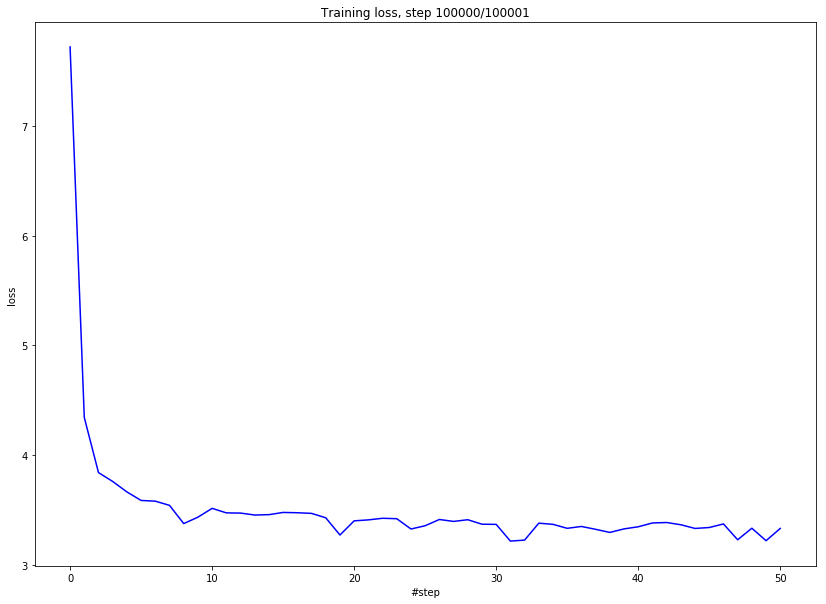

Nearest to which: that, this, usually, what, however, but, typically, cursing,
Nearest to would: will, could, can, might, may, should, must, did,
Nearest to who: he, she, actually, ever, which, gloss, still, that,
Nearest to can: could, may, will, would, should, must, might, cannot,
Nearest to their: its, his, her, your, our, the, my, some,
Nearest to to: will, must, should, would, could, veracruz, delaunay, otherwise,
Nearest to has: had, have, is, since, was, having, makes, gunships,
Nearest to is: was, has, are, became, becomes, be, seems, lies,
Nearest to zero: four, eight, five, seven, six, nine, three, two,
Nearest to at: near, in, on, individualists, counselor, under, during, from,
Nearest to after: before, during, when, while, until, despite, without, antonius,
Nearest to called: named, known, barra, woodruff, referred, used, considered, described,
Nearest to time: lawns, year, way, period, correspondance, alioth, decade, prohibitions,
Nearest to are: were, is, have, be, timbre

In [32]:
num_steps = 100001
lh = []

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            display.clear_output(wait=True)
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            lh.append(average_loss)
            average_loss = 0

            plt.figure(figsize=(14, 10))

            plt.title("Training loss, step {}/{}".format(step, num_steps))
            plt.xlabel("#step")
            plt.ylabel("loss")
            plt.plot(lh, 'b')
            plt.show()

        if step % 2000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()

### Save the word vectors and dictionaries for later use

In [33]:
def create_vec_file(final_emb_mtx, vocab_size, vec_size,filename):
    with open(filename, 'w') as f:
        f.write(str(vocab_size)+' '+str(vec_size) + '\n')
        for n in range(vocab_size):
            s = ' '.join([reverse_dictionary[n]] + [str(num) for num in final_emb_mtx[n]])
            f.write(s + '\n')

In [34]:
create_vec_file(final_embeddings, vocab_size=vocabulary_size, vec_size=embedding_size, filename='simple_cbow.w2v')
pickle.dump([dictionary, reverse_dictionary], open('dict_rdict.pkl',"wb"))

### T_SNE projection of word vectors into a 2-dimensional space

In [35]:
from sklearn.manifold import TSNE
dd = json.load(open('topical_words.json'))
colors = {'colors':'r', 'vegetables':'g', 'numbers':'b', 'professions': 'GoldenRod'}
wd = {}
for k in dd:
    for w in dd[k]:
        if w in dictionary:
            wd[w] = {'emb': final_embeddings[dictionary[w]], 'label': k, 'color': colors[k]}
            
M = np.array([wd[k]['emb'] for k in wd])
labels = [wd[k]['label'] for k in wd]
colors = [wd[k]['color'] for k in wd]

P = squareform(pdist(M, metric='cosine'))
tsne2 = TSNE(n_components=2, random_state=34, metric='precomputed', n_iter=9001)
Y = tsne2.fit_transform(P)

FileNotFoundError: [Errno 2] No such file or directory: 'topical_words.json'

In [36]:
plt.figure(figsize=(20,20))
for i, k in enumerate(wd):
    plt.scatter([Y[i][0]], [Y[i][1]], color = wd[k]['color'], label=wd[k]['label'])
    plt.annotate(k, xy=(Y[i][0], Y[i][1]), xytext=(0, 0), textcoords='offset points', 
                 color=wd[k]['color'], fontsize=12)


plt.title('T-SNE on word2vec representations, 4 topics', fontsize=16)        
plt.show()

NameError: name 'wd' is not defined

<Figure size 1440x1440 with 0 Axes>